### Step 1: Data Loading and Merging

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/Energy Prediction/"

building_metadata = pd.read_csv(base_path + "building_metadata.csv")
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")
weather_train = pd.read_csv(base_path + "weather_train.csv")
weather_test = pd.read_csv(base_path + "weather_test.csv")

### Step2: Preprocessing

* Since I wasn’t happy with my previous results, I decided to start over and study the data more carefully.
While reviewing the competition’s [discussion posts](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/112841), I realized that I had missed an important detail:
the timestamp column in the train and test files was in local time, but in the weather files, it was not.Using the information shared in the discussions, I aligned the timestamps by applying the correct timezone offsets for each site. For example:
Site 0: Orlando, FL (UTC−4), Site 1: UK (UTC+0), Site 2: Phoenix, AZ (UTC−7) and so on. This adjustment noticeably improved my model’s performance.

In [ ]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"])

In [ ]:
# hours to subtract from weather timestamp to align with local time in train-test
timezone_offsets = {
    0: 4, 1: 0, 2: 7, 3: 4, 4: 7, 5: 0, 6: 4,
    7: 4, 8: 4, 9: 5, 10: 7, 11: 4, 12: 0, 13: 5, 14: 4, 15: 4
}

# Apply to weather_train
weather_train["offset"] = weather_train["site_id"].map(timezone_offsets)
weather_train["timestamp"] = weather_train["timestamp"] - pd.to_timedelta(weather_train["offset"], unit='h')

# Drop the offset column
weather_train.drop("offset", axis=1, inplace=True)

In [ ]:
# Merge train, building_metadata and weather_train
train_merged= train.merge(building_metadata, on= "building_id", how="left")
train_final= train_merged.merge(weather_train, on=["site_id","timestamp"], how="left")

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature         106136
cloud_coverage         8830469
dew_temperature         109619
precip_depth_1_hr      3756143
sea_level_pressure     1239728
wind_direction         1458618
wind_speed              153160
dtype: int64


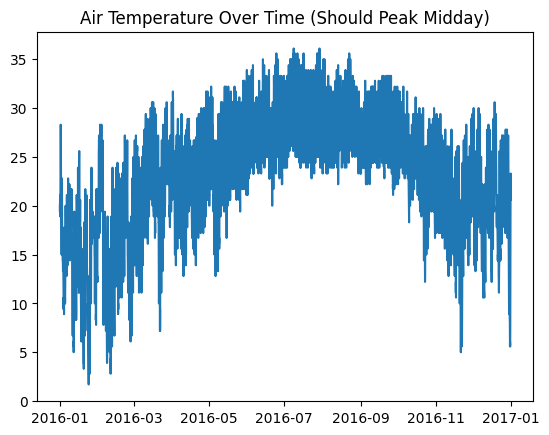

In [ ]:
#Check for missing weather data after merge
print(train_final.isnull().sum())

# Example plot for a single building to check that time alignment makes sense
import matplotlib.pyplot as plt
sample = train_final[train_final["building_id"] == 0]
plt.plot(sample["timestamp"], sample["air_temperature"])
plt.title("Air Temperature Over Time (Should Peak Midday)")
plt.show()

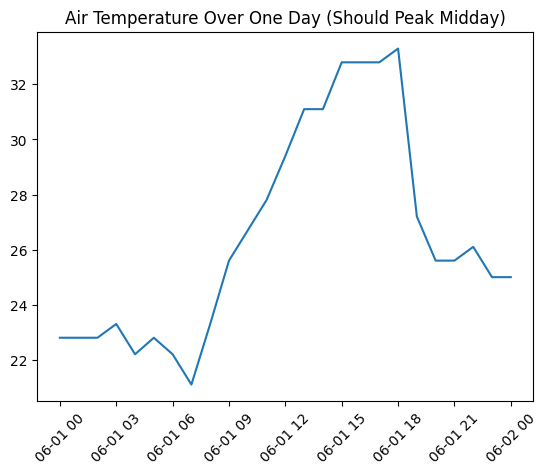

In [ ]:
# Another example check to see if air temperature picks at midday during 24 hours for a single site and if timezone alignment worked
import matplotlib.pyplot as plt
sample = train_final[train_final["site_id"] == 0]
sample_day = sample[sample["timestamp"].between("2016-06-01", "2016-06-02")]  # One day
plt.plot(sample_day["timestamp"], sample_day["air_temperature"])
plt.title("Air Temperature Over One Day (Should Peak Midday)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# To not lose the original file
train_final_org=train_final.copy()

* While exploring the data more deeply, I came across several values that didn’t make sense. For example, some rows had timestamps before the year_built, so I decided to drop those.There were also negative values in meter_reading, which are not possible in reality and likely indicate sensor errors, so I removed those rows as well. Furthermore, in order to make the data more clean and avoid giving noise to model I decided to set the constant numbers lasting more than 48 hours TO NaNs, since these were most likely caused by faulty sensors. I also handled unrealistic jumps, extreme spikes, and ultra-extreme spikes in meter_reading that could affect the model’s learning. These steps improved my model performance considerably:

In [ ]:
def filter_anomalies(df,
                    drop_nonpositive=True,
                    jump_ratio_thresh=100,    # Maximum allowed ratio in current reading/previous reading
                    zero_streak_max=48,       # Maximum allowed constant readings
                    global_quantile=0.999,    # Upper percentile threshold to clip extreme global spikes
                    verbose=True):

    n_start = len(df)

    # Ensure timestamp is datetime
    if not np.issubdtype(df["timestamp"].dtype, np.datetime64):
        df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Remove non-positive readings ---
    if drop_nonpositive:
        mask = df["meter_reading"] > 0
        if verbose:
            print(f"Dropping non-positive readings: {(~mask).sum():,}")
        df = df[mask]

    # Remove readings before building existed
    if "year_built" in df.columns:
        mask = df["year_built"].isna() | (df["timestamp"].dt.year >= df["year_built"])
        if verbose:
            print(f"Dropping readings before year_built: {(~mask).sum():,}")
        df = df[mask]

    # Sort for group operations
    df = df.sort_values(["building_id", "meter", "timestamp"]).reset_index(drop=True)

    # Handle long constant numbers
    def flag_long_constant_streaks(x, max_streak=zero_streak_max):
        diff = x.diff()  # Difference from previous
        constant_mask = (diff == 0)  # True where value same as prev
        group_ids = (constant_mask != constant_mask.shift()).cumsum()
        streak_sizes = constant_mask.groupby(group_ids).transform("sum") + 1  # +1 for streak length
        return constant_mask & (streak_sizes > max_streak)

    zero_streak_mask = df.groupby(["building_id", "meter"])["meter_reading"].transform(flag_long_constant_streaks)
    df.loc[zero_streak_mask, "meter_reading"] = np.nan
    if verbose:
        print(f"Set {zero_streak_mask.sum():,} readings to NaN due to long constant streaks")

    # Remove unrealistic jumps
    prev = df.groupby(["building_id", "meter"])["meter_reading"].shift(1)
    ratio = df["meter_reading"] / prev
    mask_jump = prev.isna() | ((ratio <= jump_ratio_thresh) & (ratio >= 1/jump_ratio_thresh))
    df = df[mask_jump]
    if verbose:
        print(f"Rows after jump filtering: {len(df):,}")

    # Cap extreme spikes per building
    def cap_building_spikes(x, low_quant=0.001, high_quant=global_quantile):
        if len(x) < 10:
            return x
        lower = x.quantile(low_quant)
        upper = x.quantile(high_quant)
        return np.clip(x, lower, upper)

    df["meter_reading"] = df.groupby(["building_id", "meter"])["meter_reading"].transform(cap_building_spikes)

    # Remove ultra-extreme global spikes
    global_thresh = df["meter_reading"].quantile(global_quantile)
    mask_global = df["meter_reading"] < global_thresh
    if verbose:
        print(f"Removing {len(df) - mask_global.sum():,} rows above {global_quantile*100:.2f} percentile ({global_thresh:.2f})")
    df = df[mask_global].reset_index(drop=True)

    if verbose:
        print(f"Finished cleaning. Total rows: {len(df):,} "
              f"(dropped {n_start - len(df):,} rows, {100*((n_start - len(df)) / n_start):.2f}%)")
    return df

In [ ]:
# Apply the function to train_final
train_final = filter_anomalies(train_final)

Dropping non-positive readings: 1,873,976
Dropping readings before year_built: 8,782
Set 258,941 readings to NaN due to long constant streaks
Rows after jump filtering: 18,313,046
Removing 275,628 rows above 99.90 percentile (41510.12)
Finished cleaning. Total rows: 18,037,418 (dropped 2,178,682 rows, 10.78%)


* Filling in missing data: I filled missing meter_reading values by doing forward and backward fill within each building. And then, in order to fill any remaining NaNs I used the median across buildings in the same site at that timestamp.

In [ ]:
# Sort
train_final = train_final.sort_values(["building_id", "timestamp"])

# Fill missing meter_readings per building
def fill_meter_readings(group):
    group["meter_reading"] = group["meter_reading"].ffill().bfill()
    return group

train_final = (
    train_final
    .groupby("building_id", group_keys=False)
    .apply(fill_meter_readings)
)

# Fill any remaining NaNs using median across buildings in the same site
def site_adjust(group):
    if group["meter_reading"].isna().any():
        median_readings = group.groupby("timestamp")["meter_reading"].transform("median")
        group["meter_reading"] = group["meter_reading"].fillna(median_readings)
    return group

# Apply site adjustment once, reset index
train_final = (
    train_final
    .groupby("site_id", group_keys=False)
    .apply(site_adjust)
)

# Check
print("Remaining NaNs after filling:", train_final["meter_reading"].isna().sum())

/tmp/ipython-input-2414991534.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_meter_readings)


Remaining NaNs after filling: 0


/tmp/ipython-input-2414991534.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(site_adjust)


In [ ]:
# Dropping floor_count since it has too many missing data
train_final= train_final.drop("floor_count", axis=1)

*  I found that using time-based interpolation worked much better for this dataset than standard linear interpolation. The rest of the imputation methods for each column were mostly the same as in the exploration_1 notebook:

In [ ]:
# Sort first
train_final = train_final.sort_values(["site_id", "timestamp"])

# Perform group-wise time interpolation
train_final["air_temperature"] = (
    train_final.groupby("site_id", group_keys=False)
    .apply(lambda group: group.set_index("timestamp")["air_temperature"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

train_final["air_temperature"].isna().sum()

/tmp/ipython-input-39272095.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.set_index('timestamp')['air_temperature']


np.int64(0)

In [ ]:
# Interpolate dew_temperature per site
train_final["dew_temperature"] = (
    train_final.groupby("site_id", group_keys=False)
    .apply(lambda g: g.set_index("timestamp")["dew_temperature"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

# Check missing values
train_final["dew_temperature"].isna().sum()

/tmp/ipython-input-464506169.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('timestamp')['dew_temperature']


np.int64(0)

In [ ]:
# Interpolate where possible
train_final["sea_level_pressure"] = (
    train_final.groupby("site_id", group_keys=False)
    .apply(lambda g: g.set_index("timestamp")["sea_level_pressure"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

# Fill remaining NaNs with site median (for site 5 and edges)
train_final["sea_level_pressure"] = train_final.groupby("site_id")["sea_level_pressure"].transform(lambda x: x.fillna(train_final["sea_level_pressure"].median()))

# Final check
train_final["sea_level_pressure"].isna().sum()

/tmp/ipython-input-538091032.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('timestamp')['sea_level_pressure']


np.int64(0)

In [ ]:
# Sort by site and timestamp
train_final = train_final.sort_values(["site_id", "timestamp"])

# Interpolate wind_speed using time method
train_final["wind_speed"] = (
    train_final.groupby("site_id", group_keys=False)
    .apply(lambda g: g.set_index("timestamp")["wind_speed"]
           .interpolate(method="time", limit_direction="both"))
    .reset_index(level=0, drop=True)
)

# Smooth the series to reduce spikes (wind_speed has short-term spikes likely caused by sensor noise. I smoothed it using a rolling mean to reduce noise)
train_final["wind_speed"] = train_final.groupby("site_id")["wind_speed"].transform(lambda x: x.rolling(3, min_periods=1, center=True).mean())

# Check missingness
train_final["wind_speed"].isna().sum()

/tmp/ipython-input-4139594362.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('timestamp')['wind_speed']


np.int64(0)

In [ ]:
# Convert wind_direction into sine and cosine components.
train_final["wind_dir_sin"] = np.sin(np.deg2rad(train_final["wind_direction"]))
train_final["wind_dir_cos"] = np.cos(np.deg2rad(train_final["wind_direction"]))

train_final["wind_dir_sin"] = train_final.groupby("site_id")["wind_dir_sin"].transform(lambda x: x.interpolate())
train_final["wind_dir_cos"] = train_final.groupby("site_id")["wind_dir_cos"].transform(lambda x: x.interpolate())

train_final["wind_dir_sin"] = train_final.groupby("site_id")["wind_dir_sin"].transform(lambda x: x.ffill().bfill())
train_final["wind_dir_cos"] = train_final.groupby("site_id")["wind_dir_cos"].transform(lambda x: x.ffill().bfill())

train_final["wind_dir_sin"].isna().sum()
train_final["wind_dir_cos"].isna().sum()

np.int64(0)

In [ ]:
train_final = train_final.sort_values(["site_id", "timestamp"])

# Apply fixes inside each site group
def interpolate_precip(group):
    group = group.set_index("timestamp")
    group["precip_depth_1_hr"] = group["precip_depth_1_hr"].apply(lambda x: np.nan if x < 0 else x) # To convert negative values to NaN
    group["precip_depth_1_hr"] = group["precip_depth_1_hr"].interpolate(method="time", limit_direction="both")
    group["precip_depth_1_hr"] = group["precip_depth_1_hr"].ffill().bfill()
    return group.reset_index()

# Apply per site
train_final = train_final.groupby("site_id", group_keys=False).apply(interpolate_precip)

# Fill sites that were completely missing with 0
train_final["precip_depth_1_hr"] = train_final["precip_depth_1_hr"].fillna(0)

# Check missingness again
train_final["precip_depth_1_hr"].isna().mean()

/tmp/ipython-input-3918357158.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_final = train_final.groupby('site_id', group_keys=False).apply(interpolate_precip)


np.float64(0.0)

* Imputing Missing Values in cloud_coverage: I learned about this approach after reading some resources on handling missing weather data.
To fill missing values, I first used the median for each site-hour combination.
If a site had all values missing for a certain hour, I used the median across all sites as a fallback.
This helps keep the imputed values realistic and consistent with typical cloud patterns.

In [ ]:
# Compute site-hour median map
site_hour_median = (
    train_final.groupby(["site_id", "hour"])["cloud_coverage"]
    .median()
    .reset_index()
    .rename(columns={"cloud_coverage": "cloud_median"})
)

# Merge to fill missing values
train_final = train_final.merge(site_hour_median, on=["site_id", "hour"], how="left")

# Fill missing with site-hour median
train_final["cloud_coverage"] = train_final["cloud_coverage"].fillna(train_final["cloud_median"])

# Use global hour median for sites fully missing
hour_median = (
    train_final.groupby("hour")["cloud_coverage"].median()
)
train_final["cloud_coverage"] = train_final.apply(
    lambda row: hour_median[row["hour"]] if pd.isna(row["cloud_coverage"]) else row["cloud_coverage"],
    axis=1
)

# Drop cloud_median column
train_final = train_final.drop(columns="cloud_median")

# Check missingness
train_final["cloud_coverage"].isna().mean()

np.float64(0.0)

* The approach I used above worked well on the training data, but it used too much RAM when applied to the test file in the final_model notebook. So I kept the same logic but rewrote the code in a more memory efficient way

In [ ]:
# Compute site-hour median
site_hour_median = train_final.groupby(["site_id", "hour"])["cloud_coverage"].median().rename("median")

# Align medians to the full DataFrame
keys_train = pd.MultiIndex.from_frame(train_final[["site_id", "hour"]])
median_aligned_train = pd.Series(site_hour_median.reindex(keys_train).values, index=train_final.index)

# Fill missing site-hour values
train_final["cloud_coverage"] = train_final["cloud_coverage"].fillna(median_aligned_train)

# Fallback: hour-only median
hour_median_train = train_final.groupby("hour")["cloud_coverage"].median()
train_final["cloud_coverage"] = train_final["cloud_coverage"].fillna(train_final["hour"].map(hour_median_train))

print("Train missing proportion:", train_final["cloud_coverage"].isna().mean())

Train missing proportion: 0.0


In [ ]:
# The same approach as before
global_year_built_median=train_final["year_built"].median()

site_year_built_medians=train_final.groupby("site_id")["year_built"].median()

site_year_built_medians=site_year_built_medians.fillna(global_year_built_median)

train_final["site_year_built_medians"]=train_final["site_id"].map(site_year_built_medians)

train_final["year_built"]=train_final["year_built"].fillna(train_final["site_year_built_medians"])

train_final=train_final.drop("site_year_built_medians", axis=1)

train_final["year_built"].isna().sum()

np.int64(0)

### Step 3: Feature Engineering
The feature engineering steps in this notebook are largely based on the approaches I used in exploration_1, with some refinements based on what I learned from my earlier experiments.

In [ ]:
# Create new time_based features
train_final["hour"]=train_final["timestamp"].dt.hour
train_final["hour_sin"] = np.sin(2 * np.pi * train_final["hour"] / 24)
train_final["hour_cos"] = np.cos(2 * np.pi * train_final["hour"] / 24)
train_final["day_of_week"]=train_final["timestamp"].dt.dayofweek
train_final["month"]=train_final["timestamp"].dt.month
train_final["month_sin"] = np.sin(2 * np.pi * train_final["month"] / 12)
train_final["month_cos"] = np.cos(2 * np.pi * train_final["month"] / 12)
train_final["is_weekend"]=(train_final["day_of_week"]>=5).astype(int)

In [ ]:
# Bin year_built to 5 categorical features
bins = [1900, 1950, 1980, 2000, 2011, 2018]
labels = ["Before1950", "1950-1979", "1980-1999", "2000-2010", "After2010"]
train_final["building_age_group"] = pd.cut(train_final["year_built"], bins=bins, labels=labels)

In [ ]:
train_final["building_age_group"] = train_final["building_age_group"].astype("category')
train_final["building_age_group"] = train_final["building_age_group"].cat.add_categories(["Unknown"])
train_final["building_age_group"] = train_final["building_age_group"].fillna("Unknown")

In [ ]:
# Create new features
train_final["air_temp_wind"] = train_final["air_temperature"] * train_final["wind_speed"]
train_final["air_temp_cloud"] = train_final["air_temperature"] * train_final["cloud_coverage"]
train_final["dew_temp_wind"] = train_final["dew_temperature"] * train_final["wind_speed"]

In [ ]:
# Drop the unnecessary columns
train_final = train_final.drop(
    ["timestamp", "hour", "month", "year_built", "wind_direction"],
    axis=1
)

In [ ]:
# Reduce memory usage
for col in train_final.select_dtypes(include=["float64"]).columns:
    train_final[col] = train_final[col].astype("float32")
for col in train_final.select_dtypes(include=["int64"]).columns:
    train_final[col] = train_final[col].astype("int32")

In [ ]:
# Sample 70% of the data from each site, then split it into training and validation sets
from sklearn.model_selection import train_test_split
train_final_sample = train_final.groupby("site_id", group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=42))

X = train_final_sample.drop(columns=["meter_reading"])
y = train_final_sample["meter_reading"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_final_sample["site_id"])

/tmp/ipython-input-1472831582.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_final_sample = train_final.groupby('site_id', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=42))


In [ ]:
# Confirm that site_id proportions after sampling are same as before
train_final_sample["site_id"].value_counts() / len(train_final_sample)

,count
site_id,
9,0.137996
13,0.131009
3,0.130573
2,0.123008
14,0.120035
15,0.095922
5,0.042022
4,0.041162
0,0.039615


In [ ]:
train_final["site_id"].value_counts() / len(train_final)

,count
site_id,
9,0.137996
13,0.131009
3,0.130573
2,0.123008
14,0.120035
15,0.095922
5,0.042022
4,0.041162
0,0.039615


In [ ]:
import xgboost as xgb
print(xgb.__version__)

3.1.1


In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


* In my exploration_1 notebook, I wasn’t sure how to handle a high-cardinality feature like building_id. Since my goal in this notebook was to build site-based models, and after doing some research on how tree-based models handle categorical ids, I decided that label encoding was a reasonable and safe choice for this feature.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make copies just in case
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()

building_encoders = {}

# Unique sites for efficiency
sites = X_train_encoded["site_id"].unique()

for site in sites:
    le = LabelEncoder()
    train_mask = X_train_encoded["site_id"] == site
    val_mask = X_val_encoded["site_id"] == site

    le.fit(X_train_encoded.loc[train_mask, "building_id"])
    building_encoders[site] = le

    # Transform train
    X_train_encoded.loc[train_mask, "building_id"] = le.transform(
        X_train_encoded.loc[train_mask, "building_id"]
    )
    # Transform val with unseen handling
    X_val_encoded.loc[val_mask, "building_id"] = X_val_encoded.loc[val_mask, "building_id"].map(
        lambda x: le.transform([x])[0] if x in le.classes_ else le.classes_.size
    )

/tmp/ipython-input-2076830473.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[109  34  87 ...   9  20  31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train_encoded.loc[train_mask, 'building_id'] = le.transform(
/tmp/ipython-input-2076830473.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[103  71  16 ...  40  58  14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_val_encoded.loc[val_mask, 'building_id'] = X_val_encoded.loc[val_mask, 'building_id'].map(


* The approach I used above worked well on the training data, but it took way too long to execute when applied to the test file in the final_model notebook. So I kept the same logic but rewrote the code in a more time efficient way.

In [ ]:
# Make copies
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()

# Dictionary to store encoders per site
building_encoders = {}

# Unique sites
sites = X_train_encoded["site_id"].unique()

for site in sites:
    # Create a LabelEncoder for this site
    le = LabelEncoder()
    train_mask = X_train_encoded["site_id"] == site
    val_mask = X_val_encoded["site_id"] == site

    # Fit on train site buildings
    le.fit(X_train_encoded.loc[train_mask, "building_id"])
    building_encoders[site] = le

    # Encode train
    X_train_encoded.loc[train_mask, "building_id"] = le.transform(
        X_train_encoded.loc[train_mask, "building_id"]
    )

    # Vectorized encode for test
    known_classes = pd.Series(np.arange(len(le.classes_)), index=le.classes_)
    X_val_encoded.loc[val_mask, "building_id"] = (
        X_val_encoded.loc[val_mask, "building_id"]
        .map(known_classes)
        .fillna(len(le.classes_))
        .astype(int)
    )

print(" Building ID encoding complete (vectorized, memory-safe).")


/tmp/ipython-input-3039962799.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[109  34  87 ...   9  20  31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train_encoded.loc[train_mask, 'building_id'] = le.transform(
/tmp/ipython-input-3039962799.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[103  71  16 ...  40  58  14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_val_encoded.loc[val_mask, 'building_id'] = (


 Building ID encoding complete (vectorized, memory-safe).


### Step 4: Pre model setup

In [ ]:
X_train_encoded.columns

Index(['building_id', 'meter', 'site_id', 'primary_use', 'square_feet',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 'hour_sin',
       'hour_cos', 'day_of_week', 'month_sin', 'month_cos', 'is_weekend',
       'wind_dir_sin', 'wind_dir_cos', 'building_age_group', 'air_temp_wind',
       'air_temp_cloud', 'dew_temp_wind'],
      dtype='object')

In [ ]:
selected_features= ["building_id", "meter", "site_id", "primary_use", "square_feet",
       "air_temperature", "cloud_coverage", "dew_temperature",
       "precip_depth_1_hr", "sea_level_pressure", "wind_speed", "hour_sin",
       "hour_cos", "day_of_week", "month_sin", "month_cos", "is_weekend",
       "wind_dir_sin", "wind_dir_cos", "building_age_group", "air_temp_wind",
       "air_temp_cloud", "dew_temp_wind"]

numerical_features= ["square_feet",
       "air_temperature", "cloud_coverage", "dew_temperature",
       "precip_depth_1_hr", "sea_level_pressure", "wind_speed", "hour_sin",
       "hour_cos", "day_of_week", "month_sin", "month_cos", "is_weekend",
       "wind_dir_sin", "wind_dir_cos", "air_temp_wind",
       "air_temp_cloud", "dew_temp_wind"]

categorical_features= ["building_id", "meter", "site_id", "building_age_group", "primary_use"]

In [ ]:
X_train_final = X_train_encoded[selected_features]
X_val_final = X_val_encoded[selected_features]

In [ ]:
# Define an RMSLE metric as a scorer for RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

def rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(
    rmsle, greater_is_better=False  # Because RandomizedSearchCV maximizes
)

### Step 5: Final Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor

In [ ]:
# Search space for hyperparameter tuning
from scipy.stats import randint, uniform

param_dist_xgb1 = {
    "regressor__n_estimators"     : randint(150, 400),
    "regressor__max_depth"        : randint(3, 7),
    "regressor__learning_rate"    : uniform(0.02, 0.18),
    "regressor__subsample"        : uniform(0.6, 0.4),
    "regressor__colsample_bytree" : uniform(0.6, 0.4),
    "regressor__min_child_weight" : randint(3, 50),
    "regressor__reg_alpha"        : uniform(0.0, 1.5),
    "regressor__reg_lambda"       : uniform(0.5, 3.0)
}

param_dist_lgb1 = {
    "regressor__n_estimators"     : randint(150, 400),
    "regressor__max_depth"        : randint(3, 8),
    "regressor__learning_rate"    : uniform(0.02, 0.18),
    "regressor__num_leaves"       : randint(15, 80),
    "regressor__subsample"        : uniform(0.6, 0.4),
    "regressor__colsample_bytree" : uniform(0.6, 0.4),
    "regressor__min_child_samples": randint(5, 100),
    "regressor__lambda_l1"        : uniform(0.0, 1.5),
    "regressor__lambda_l2"        : uniform(0.5, 3.0)
}

* I attempted to use early stopping to reduce overfitting, but I kept running into an error that I wasn’t able to resolve at the time.
Even without early stopping, the comparison between the training and validation RMSLE showed only moderate overfitting on three sites: 7, 10, and 11.

In [ ]:
# Training loop
best_models = {}
best_params_dict = {}
results = []

for site in range(16):
    print(f" Training Site {site}...")

    # Filter site data
    mask_train = X_train_final["site_id"] == site
    mask_val = X_val_final["site_id"] == site

    if mask_train.sum() == 0 or mask_val.sum() == 0:
        print(f"Skipping site {site}: no data")
        continue

    X_train_site = X_train_final[mask_train].drop(columns=["site_id"])
    X_val_site = X_val_final[mask_val].drop(columns=["site_id"])
    y_train_site = y_train[mask_train]
    y_val_site = y_val[mask_val]

    # Ensure categorical dtypes
    for col in cat_cols_site:
        if col in X_train_site.columns:
            X_train_site[col] = X_train_site[col].astype("category")
            X_val_site[col] = X_val_site[col].astype("category")

    # XGBoost
    xgb_base = XGBRegressor(
        enable_categorical=True,
        tree_method="hist",
        random_state=42 + site,
        eval_metric="rmsle"
    )

    xgb_model = TransformedTargetRegressor(
        regressor=xgb_base,
        func=np.log1p,
        inverse_func=np.expm1,
        check_inverse=False
    )

    search_xgb = RandomizedSearchCV(
        xgb_model,
        param_dist_xgb1,
        n_iter=15,
        cv=3,
        scoring=rmsle_scorer,
        random_state=100 + site,
        n_jobs=1
    )

    search_xgb.fit(X_train_site, y_train_site)
    print(f"  Best XGB params: {search_xgb.best_params_}")

    # LightGBM
    lgb_base = LGBMRegressor(
        random_state=42 + site,
        metric="rmsle",
        verbosity=-1
    )

    lgb_model = TransformedTargetRegressor(
        regressor=lgb_base,
        func=np.log1p,
        inverse_func=np.expm1,
        check_inverse=False
    )

    search_lgb = RandomizedSearchCV(
        lgb_model,
        param_dist_lgb1,
        n_iter=15,
        cv=3,
        scoring=rmsle_scorer,
        random_state=200 + site,
        n_jobs=1
    )

    search_lgb.fit(X_train_site, y_train_site)
    print(f"  Best LGB params: {search_lgb.best_params_}")

    # Pick best model
    if -search_xgb.best_score_ < -search_lgb.best_score_:
        best_model = search_xgb.best_estimator_
        model_name = "XGBoost"
    else:
        best_model = search_lgb.best_estimator_
        model_name = "LightGBM"

    # Evaluate and check for overfitting
    y_pred_val = best_model.predict(X_val_site)
    val_rmsle = rmsle(y_val_site, y_pred_val)
    y_pred_train = best_model.predict(X_train_site)
    train_rmsle = rmsle(y_train_site, y_pred_train)

    print(f" Site {site} | Best: {model_name} | Val RMSLE: {val_rmsle:.4f} | Train RMSLE: {train_rmsle:.4f}")

    # Save best params (tuned ones)
    if model_name == "XGBoost":
        best_params_dict[site] = search_xgb.best_params_
    else:
        best_params_dict[site] = search_lgb.best_params_

    # Save Results
    best_models[f"site_{site}"] = {
        "model": best_model,
        "type": model_name,
        "val_rmsle": val_rmsle,
        "train_rmsle": train_rmsle,
        "encoder": building_encoders.get(site)
    }
    results.append({
        "site": site,
        "model": model_name,
        "val_rmsle": val_rmsle,
        "train_rmsle": train_rmsle
    })

# After all sites are trained
print("Training complete!")

results_df = pd.DataFrame(results)
display(results_df.sort_values("val_rmsle"))

# Save to use later in final_model.ipynb
import joblib

joblib.dump(best_params_dict, "/content/drive/MyDrive/best_params_per_site.pkl")
joblib.dump(best_models, "/content/drive/MyDrive/best_models_per_site.pkl")

print("Files saved successfully to Google Drive!")

 Training Site 0...
  Best XGB params: {'regressor__colsample_bytree': np.float64(0.7143582761627458), 'regressor__learning_rate': np.float64(0.17343111581143514), 'regressor__max_depth': 6, 'regressor__min_child_weight': 23, 'regressor__n_estimators': 357, 'regressor__reg_alpha': np.float64(0.998540062749846), 'regressor__reg_lambda': np.float64(0.5341688304884494), 'regressor__subsample': np.float64(0.643167106374489)}
  Best LGB params: {'regressor__colsample_bytree': np.float64(0.9864178356144122), 'regressor__lambda_l1': np.float64(1.1380506190282018), 'regressor__lambda_l2': np.float64(2.538925502678697), 'regressor__learning_rate': np.float64(0.07928265868589743), 'regressor__max_depth': 7, 'regressor__min_child_samples': 67, 'regressor__n_estimators': 389, 'regressor__num_leaves': 67, 'regressor__subsample': np.float64(0.989131675879468)}
 Site 0 | Best: XGBoost | Val RMSLE: 0.2392 | Train RMSLE: 0.2263
 Training Site 1...
  Best XGB params: {'regressor__colsample_bytree': np.f

,site,model,val_rmsle,train_rmsle
4,4,LightGBM,0.142862,0.138321
1,1,XGBoost,0.155607,0.143347
3,3,XGBoost,0.207624,0.204310
12,12,LightGBM,0.213943,0.198246
0,0,XGBoost,0.239162,0.226281
15,15,LightGBM,0.300589,0.291195
8,8,XGBoost,0.303367,0.293253
9,9,LightGBM,0.324557,0.314164
5,5,LightGBM,0.357108,0.343340
6,6,LightGBM,0.375540,0.354015


Files saved successfully to Google Drive!


### Conclusion
The RMSLE scores were good enough to justify using this model. It’s worth noting that this final model was the result of many trial and error experiments and most of those attempts were removed from this notebook to keep it clean and avoid redundant code.